# Convolutional Neural Network With PyTorch
----------------------------------------------

Here I only train for a few epochs as training takes couple of hours without GPU.  But this network achieves 0.995 accuracy
after 50 epochs of training.

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

## Explore the Data

In [2]:
train_df = pd.read_csv('./train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print("Number of training samples:",n_train) #{0}'.format(n_train))
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 42000
Number of training pixels:  784
Number of classes:  10


In [3]:
test_df = pd.read_csv('./test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: ', n_test)
print('Number of test pixels: ', n_pixels)

Number of train samples:  28000
Number of test pixels:  784


In [40]:
test_labeled_df = pd.read_csv('./test_labeled.csv', sep=';')

n_test = len(test_labeled_df)
n_pixels = len(test_labeled_df.columns) - 1

print('Number of train samples: ', n_test)
print('Number of test pixels: ', n_pixels)

Number of train samples:  28000
Number of test pixels:  784


In [5]:
binary_df = train_df.loc[train_df['label'] < 2]

n_binary = len(binary_df)
n_pixels = len(binary_df.columns) - 1
n_class = len(set(binary_df['label']))

print("Number of training samples:",n_binary) #{0}'.format(n_train))
print("Number of training pixels: ", n_pixels)
print("Number of classes: ", n_class)
#print(binary_df)


Number of training samples: 8816
Number of training pixels:  784
Number of classes:  2


In [6]:
print("Shape of the train_df is: ", train_df.shape)
print("Shape of the test_df is: ", test_df.shape)
print("Shape of the binary_df is: ", binary_df.shape)

Shape of the train_df is:  (42000, 785)
Shape of the test_df is:  (28000, 784)
Shape of the binary_df is:  (8816, 785)


### Display some images

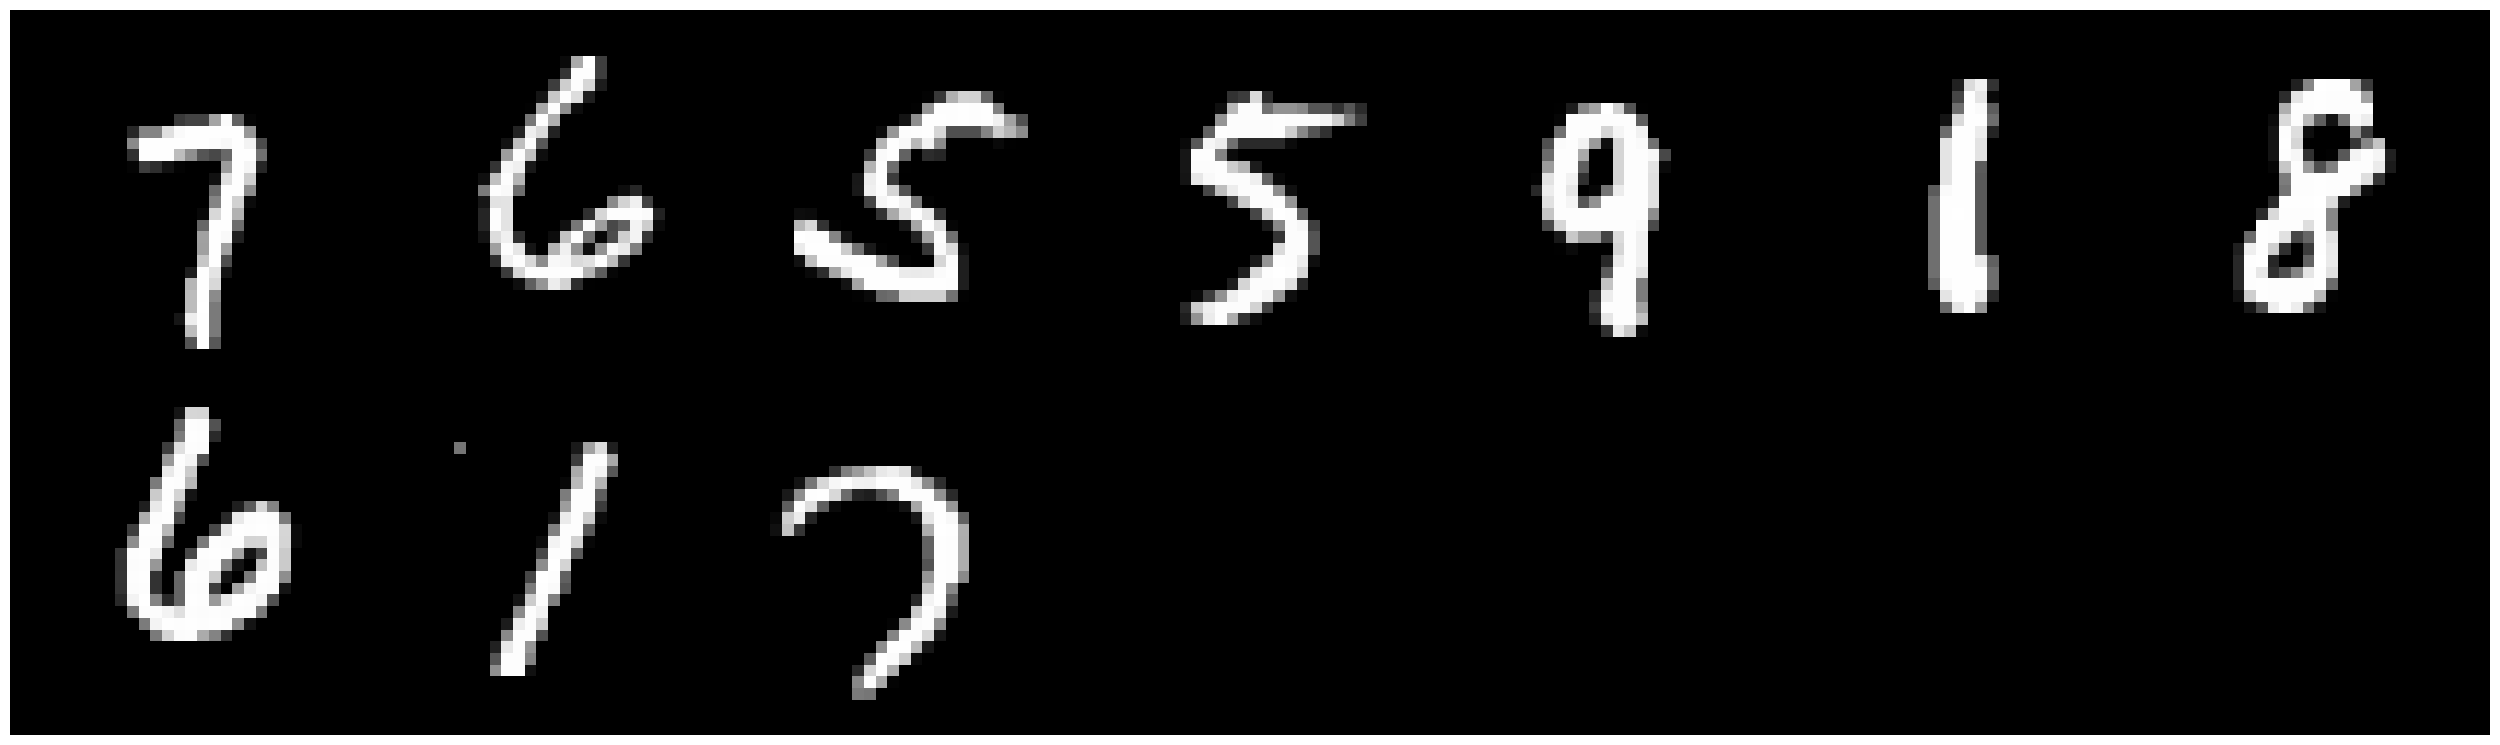

In [7]:
random_sel = np.random.randint(n_binary, size=10)

def dispImage(df, n_size):
    grid = make_grid(torch.Tensor((df.iloc[n_size, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=7)
    plt.rcParams['figure.figsize'] = (32, 150)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.axis('off')

dispImage(train_df, random_sel)
    
#print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

5, 3, 3, 9, 1, 2, 0, 2, 0, 7, 3, 5, 9, 2, 4, 0, 9, 6, 9, 2, 6, 5, 2, 3, 4, 3, 3, 3, 5, 5, 7, 3, 9, 2, 1, 9, 6, 3, 0, 4, 5, 0, 3, 3, 1, 9, 1, 4, 6, 9, 8, 9, 0, 4, 0, 5, 4, 0, 2, 2, 7, 6, 7, 6, 7, 3, 1, 2, 3, 5, 9, 5, 2, 9, 5, 2, 2, 4, 8, 7, 0, 1, 1, 8, 8, 6, 7, 7, 3, 8, 2, 6, 1, 5, 9, 4, 7, 9, 4, 7, 4, 3, 3, 2, 8, 2, 4, 4, 0, 4, 1, 4, 8, 8, 8, 8, 4, 3, 5, 9, 4, 4, 5, 9, 1, 4, 1, 1, 8, 6, 5, 2, 4, 0, 8, 4, 9, 6, 1, 5, 1, 8, 2, 6, 4, 8, 3, 3, 1, 1, 5, 1, 3, 1, 0, 4, 2, 1, 1, 7, 7, 3, 0, 1, 7, 1, 1, 7, 6, 6, 5, 2, 1, 9, 6, 7, 3, 6, 1, 8, 3, 8, 2, 1, 4, 5, 9, 8, 4, 9, 4, 5, 3, 2, 0, 9, 1, 7, 9, 4, 8, 1, 5, 1, 9, 6, 4, 7, 2, 5, 5, 5, 2, 8, 8, 8, 3, 2, 8, 8, 3, 5, 0, 9, 0, 8, 6, 8, 0, 8, 5, 9, 7, 3, 6, 4, 8, 9, 3, 5, 2, 3, 9, 6, 2, 3, 7, 2, 7, 0, 6, 3, 8, 5, 2, 4, 1, 0, 8, 8, 5, 2, 5, 0, 7, 7, 4, 0, 9, 0, 3, 0, 3, 1, 7, 1, 3, 2, 0, 3, 3, 9, 9, 4, 2, 0, 5, 2, 1, 1, 5, 5, 4, 1, 6, 1, 7, 9, 8, 1, 8, 6, 7, 6, 1, 2, 1, 9, 8, 9, 7, 4, 3, 6, 1, 4, 3, 2, 3, 4, 8, 0, 6, 7, 5, 3, 1, 2, 2, 9, 2, 6, 1, 5

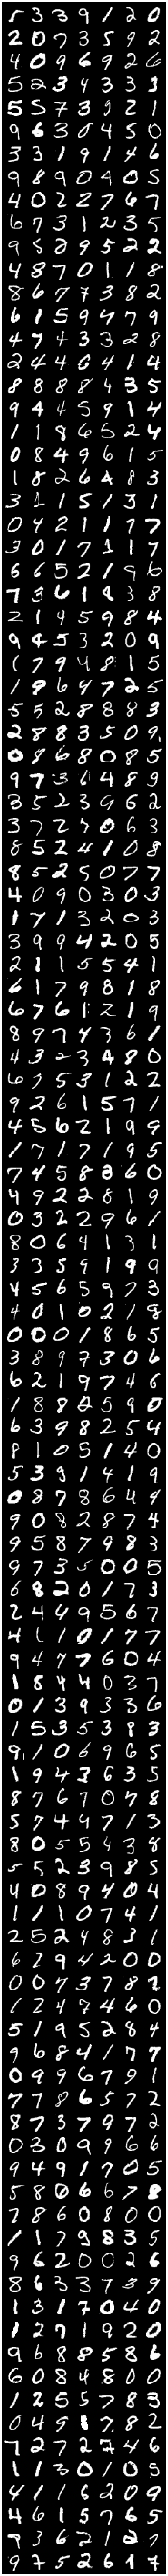

In [8]:
random_sel = np.random.randint(n_train, size=777)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=7)
plt.rcParams['figure.figsize'] = (32, 150)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

### Histogram of the classes

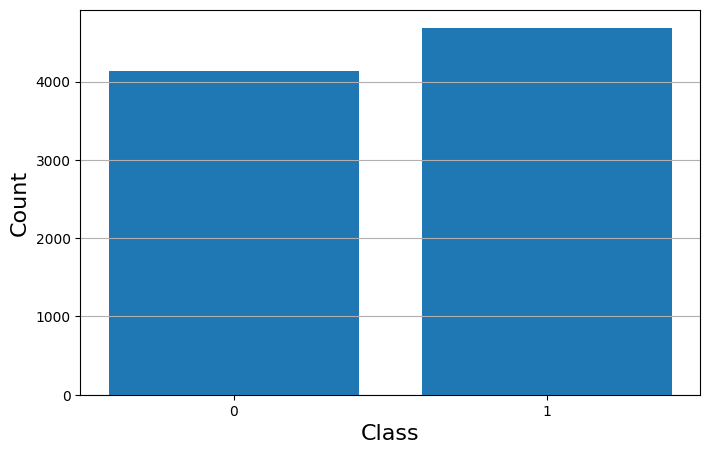

In [9]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(binary_df['label'].value_counts().index, binary_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

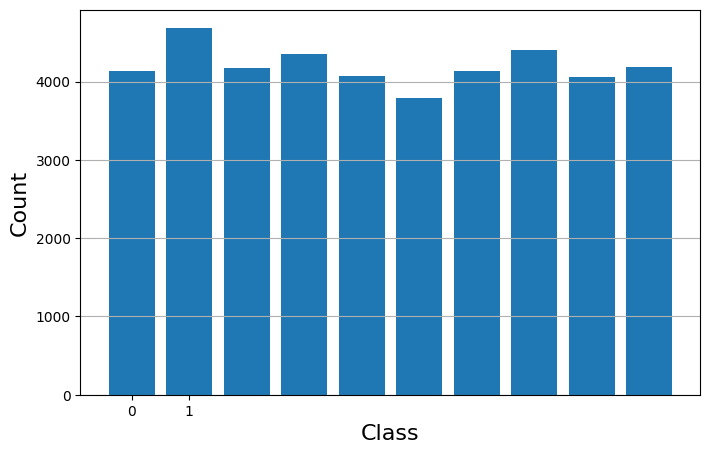

In [10]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

## Data Loader

In [11]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Random Rotation Transformation
Randomly rotate the image. Available in upcoming torchvision but not now.

In [12]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

### Random Vertical and Horizontal Shift

In [13]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

## Load the Data into Tensors
For the training set, apply random rotation within the range of (-45, 45) degrees, shift by (-3, 3) pixels
and normalize pixel values to [-1, 1].  For the test set, only apply nomalization.

In [14]:
batch_size = 64

train_dataset = MNIST_data('train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('test.csv')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

### Visualize the Transformations

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)


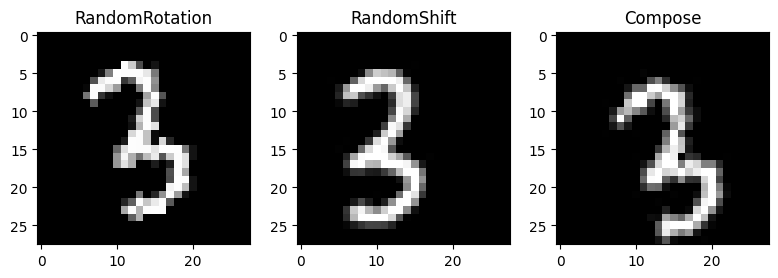

In [15]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Network Structure

In [16]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [17]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/4122321177.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


## Training and Evaluation

In [18]:
loss_values = []
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss_val = F.cross_entropy(output, target, size_average=False).data
        loss_values.append(loss_val)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    
    print(loss_values[0:5], loss_values[len(loss_values)-1] )
    plt.plot(loss_values)
    plt.ylabel('Loss')
    plt.show()

In [19]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

### Train the network

Reaches 0.995 accuracy on test set after 50 epochs

/Users/ilerisoy/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/2105636642.py:17: DeprecationWarning: BICUBIC is deprecate

Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.397809
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.274397
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.317167
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.123995
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.184011
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.061844
[tensor(205.9499), tensor(179.6982), tensor(167.1368), tensor(181.3430), tensor(154.9669)] tensor(1.7008)


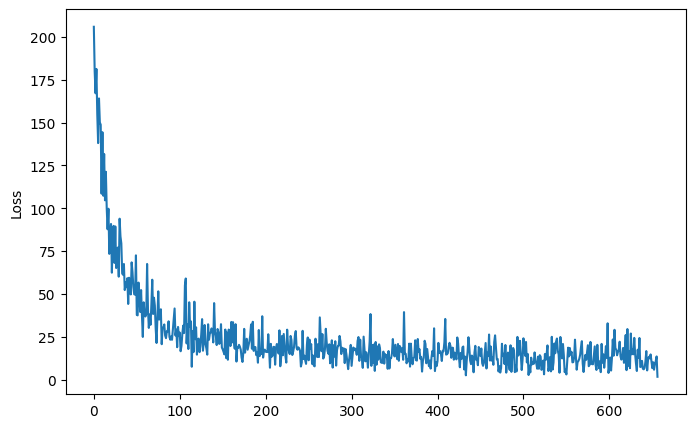

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/1182705065.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Average loss: 0.1028, Accuracy: 40673/42000 (96.840%)



In [20]:
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

## Prediction on Test Set

In [21]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        #print(output)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        #print(pred)
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [34]:
test_pred = prediciton(test_loader)

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1447/2277685750.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


In [43]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

0, 0, 0, 0, 0, 0, 0, 0


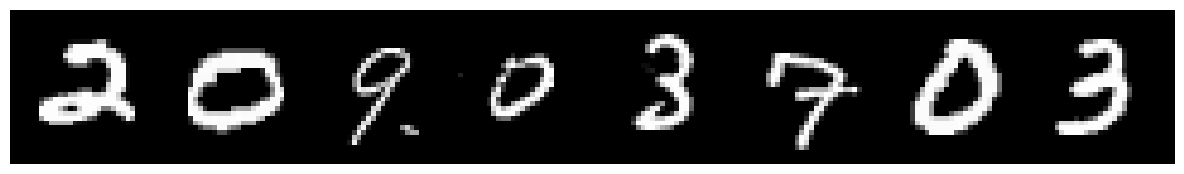

In [44]:
out_sel = [0,1,2,3,4,5,6,7]

grid = make_grid(torch.Tensor((test_df.iloc[out_sel, 0:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(test_df.iloc[out_sel, 0].values), sep = ', ')

In [46]:
test_predictions = out_df.iloc[:, 1].to_numpy()
test_labels = test_df.iloc[:,1].to_numpy()
print(len(out_df))

28000


In [50]:
count3 = 0
test_index = np.array(range(100250))

for i in range(len(test_predictions)):
    if test_labels[i] == test_predictions[i]:
        continue
    else:
        test_index[count3] = i
        count3 += 1
        print("Label is: ", test_labels[i], "Predcition is: ", 
              test_predictions[i], "index is: ", i)
print(count3)

Label is:  0 Predcition is:  2 index is:  0
Label is:  0 Predcition is:  9 index is:  2
Label is:  0 Predcition is:  9 index is:  3
Label is:  0 Predcition is:  3 index is:  4
Label is:  0 Predcition is:  7 index is:  5
Label is:  0 Predcition is:  3 index is:  7
Label is:  0 Predcition is:  3 index is:  9
Label is:  0 Predcition is:  5 index is:  10
Label is:  0 Predcition is:  7 index is:  11
Label is:  0 Predcition is:  4 index is:  12
Label is:  0 Predcition is:  4 index is:  14
Label is:  0 Predcition is:  3 index is:  15
Label is:  0 Predcition is:  3 index is:  16
Label is:  0 Predcition is:  1 index is:  17
Label is:  0 Predcition is:  9 index is:  18
Label is:  0 Predcition is:  9 index is:  20
Label is:  0 Predcition is:  1 index is:  21
Label is:  0 Predcition is:  1 index is:  22
Label is:  0 Predcition is:  5 index is:  23
Label is:  0 Predcition is:  7 index is:  24
Label is:  0 Predcition is:  4 index is:  25
Label is:  0 Predcition is:  2 index is:  26
Label is:  0 Pred

Label is:  0 Predcition is:  8 index is:  21826
Label is:  0 Predcition is:  2 index is:  21827
Label is:  0 Predcition is:  8 index is:  21828
Label is:  0 Predcition is:  1 index is:  21829
Label is:  0 Predcition is:  7 index is:  21830
Label is:  0 Predcition is:  1 index is:  21831
Label is:  0 Predcition is:  4 index is:  21833
Label is:  0 Predcition is:  8 index is:  21834
Label is:  0 Predcition is:  8 index is:  21835
Label is:  0 Predcition is:  1 index is:  21836
Label is:  0 Predcition is:  4 index is:  21837
Label is:  0 Predcition is:  7 index is:  21838
Label is:  0 Predcition is:  8 index is:  21840
Label is:  0 Predcition is:  4 index is:  21841
Label is:  0 Predcition is:  5 index is:  21843
Label is:  0 Predcition is:  8 index is:  21844
Label is:  0 Predcition is:  6 index is:  21845
Label is:  0 Predcition is:  7 index is:  21847
Label is:  0 Predcition is:  7 index is:  21848
Label is:  0 Predcition is:  5 index is:  21849
Label is:  0 Predcition is:  5 index is:

In [51]:
con_test = confusion_matrix(test_labels, test_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_test,"\n")


Confusion Matrix is:

[[2785 3177 2855 2719 2857 2507 2791 2917 2686 2706]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]] 

